# load datasets

In [111]:
import os
os.chdir("/home/rana-helal/PycharmProjects/fake_news_classifier")
print("Now at:", os.getcwd())


Now at: /home/rana-helal/PycharmProjects/fake_news_classifier


In [112]:
import importlib
import src.data_loader
importlib.reload(src.data_loader)


<module 'src.data_loader' from '/home/rana-helal/PycharmProjects/fake_news_classifier/src/data_loader.py'>

In [113]:
from src.data_loader import load_kaggle_data, load_fakenewsnet_data, load_combined_data
df_kaggle = load_kaggle_data()
df_fnn = load_fakenewsnet_data()
df_all = load_combined_data()


# eda for kaggle data

## basic infos

In [114]:
(df_kaggle.head(2))

,title,text,subject,label
0,UNREAL! OBAMA SAYS HIROSHIMA TOUR to Honor “Al...,Barack Obama s historic visit to Hiroshima thi...,politics,fake
1,Factbox: Humanitarian crisis in Bangladesh as ...,"(Reuters) - About 270,000 Muslim Rohingya flee...",worldnews,real


In [115]:
df_kaggle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   label    44898 non-null  object
dtypes: object(4)
memory usage: 1.4+ MB


In [116]:
df_kaggle.describe()

,title,text,subject,label
count,44898,44898,44898,44898
unique,38729,38646,8,2
top,Factbox: Trump fills top jobs for his administ...,,politicsNews,fake
freq,14,627,11272,23481


In [117]:
df_kaggle.shape

(44898, 4)

### distribution

In [118]:
print("Kaggle labels:", df_kaggle['label'].value_counts())


Kaggle labels: label
fake    23481
real    21417
Name: count, dtype: int64


### text length

In [143]:
print(df_kaggle['text'].apply(lambda x: len(str(x))))

0         199
1        2134
2        9352
3        4070
4        1949
         ... 
44893     314
44894    2865
44895    1930
44896    2575
44897    2403
Name: text, Length: 44898, dtype: int64


### check for null

In [120]:
df_kaggle.isnull().sum()

title      0
text       0
subject    0
label      0
dtype: int64

### check for duplicate

In [121]:
df_kaggle.duplicated().sum()

np.int64(213)

### links

In [158]:
link_percentage = df_kaggle['text'].str.contains(r"http\S+").mean() * 100
print(f"links in news: {link_percentage:.2f}%")


links in news: 7.35%


### numbers

In [159]:
number_percentage = df_kaggle['text'].str.contains(r"\d").mean() * 100
print(f"numbers in news: {number_percentage:.2f}%")

numbers in news: 80.75%


### sumbols

In [160]:
symbols_percentage = df_kaggle['text'].str.contains(r"[#@!$%^&*]").mean() * 100
print(f"symbols in news: {symbols_percentage:.2f}%")

symbols in news: 43.39%


In [180]:
pip install emoji

Note: you may need to restart the kernel to use updated packages.


In [183]:
import emoji

def contains_emoji(text):
    return any(char in emoji.EMOJI_DATA for char in str(text))

df_kaggle['has_emoji'] = df_kaggle['text'].apply(contains_emoji)
print("Emoji presence:", round(df_kaggle['has_emoji'].mean() * 100, 2), "%")


Emoji presence: 0.0 %


### check for another language

In [164]:
from langdetect import detect, LangDetectException

def safe_detect(text):
    try:
        if not text or len(text.strip()) < 3:
            return "unknown"
        return detect(text)
    except LangDetectException:
        return "unknown"

df_kaggle['lang'] = df_kaggle['text'].apply(lambda x: safe_detect(str(x)))


In [165]:
non_english_ratio = (df_kaggle['lang'] != 'en').mean() * 100
print(f"Percentage of non-English texts: {non_english_ratio:.2f}%")


Percentage of non-English texts: 1.69%


In [166]:
df_kaggle.drop(columns=['lang'], inplace=True)


## visualization

In [122]:
import seaborn as sns
import matplotlib.pyplot as plt
from src.utils.eda_utils import generate_wordcloud


### Distribution

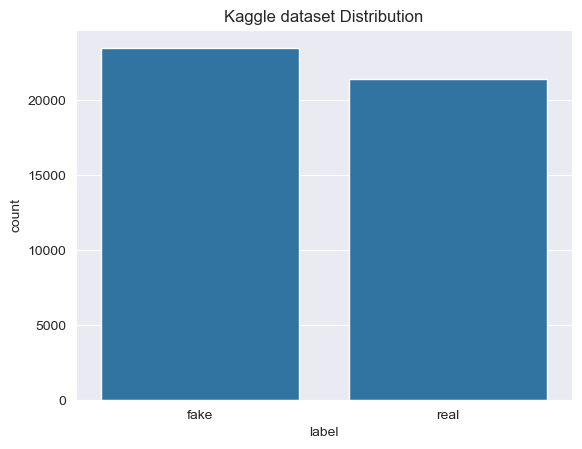

In [123]:
sns.countplot(data=df_kaggle,x='label')
plt.title('Kaggle dataset Distribution')
plt.show()

### Text Lengths

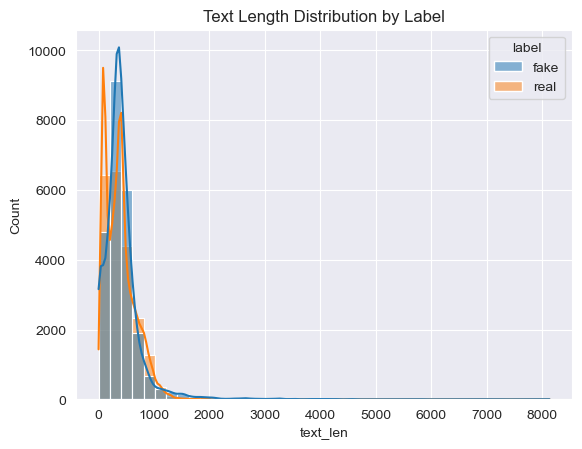

In [148]:
df_kaggle['text_len'] = df_kaggle['text'].apply(lambda x: len(str(x).split()))

sns.histplot(data=df_kaggle, x='text_len', bins=40, hue='label', kde=True)
plt.title("Text Length Distribution by Label")
plt.show()
df_kaggle.drop(columns=['text_len'], inplace=True)


### sentence length

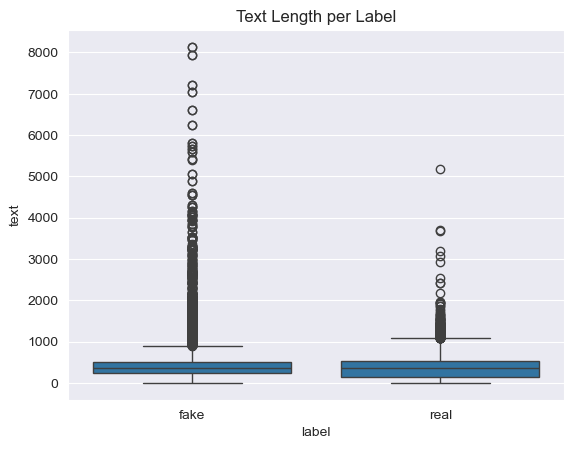

In [154]:
sns.boxplot(data=df_kaggle, x='label', y=df_kaggle['text'].apply(lambda x: len(str(x).split())))
plt.title("Text Length per Label")
plt.show()


### word cloud

In [125]:
importlib.reload(src.utils)


<module 'src.utils' from '/home/rana-helal/PycharmProjects/fake_news_classifier/src/utils.py'>

In [126]:
generate_wordcloud(df_kaggle, label="fake", source="kaggle")


In [127]:
generate_wordcloud(df_kaggle, label="real", source="kaggle")


### top words


In [172]:
importlib.reload(src.eda.eda_utils)

from src.utils.eda_utils import get_top_n_words
from src.utils.eda_utils import plot_top_words

real_texts = df_kaggle[df_kaggle['label'] == 'real']['text'].dropna().astype(str)
real_texts = get_top_n_words(real_texts, n=20)

In [176]:
fake_texts = df_kaggle[df_kaggle['label'] == 'fake']['text'].dropna().astype(str)
fake_texts = get_top_n_words(fake_texts, n=20)

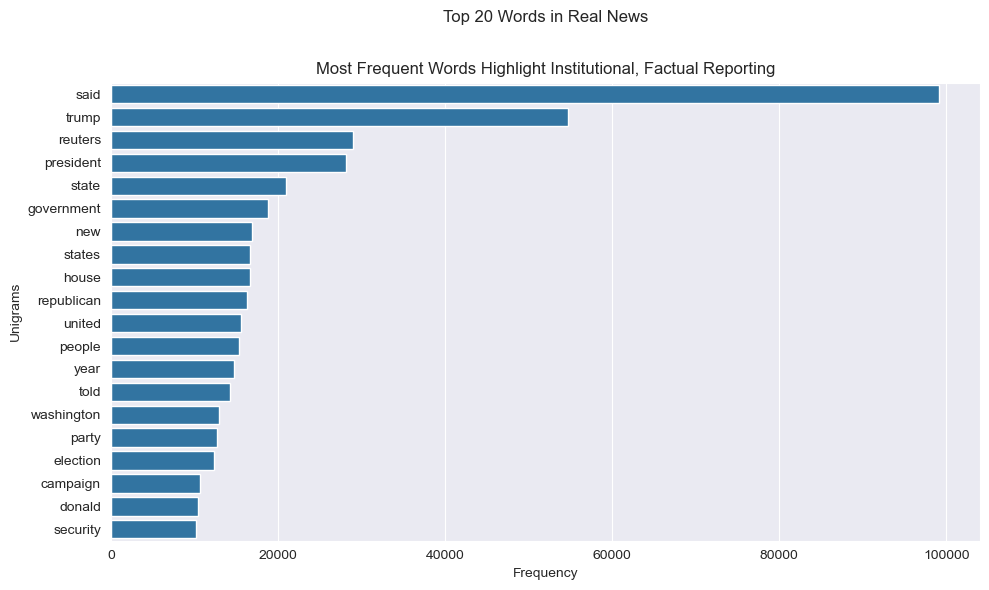

In [175]:
import pandas as pd

real_texts= pd.DataFrame(real_texts, columns=['word', 'freq'])
plot_top_words(
    real_texts,
    title='Top 20 Words in Real News\n\n\nMost Frequent Words Highlight Institutional, Factual Reporting',
    x_label='Frequency',
    y_label='Unigrams',
)

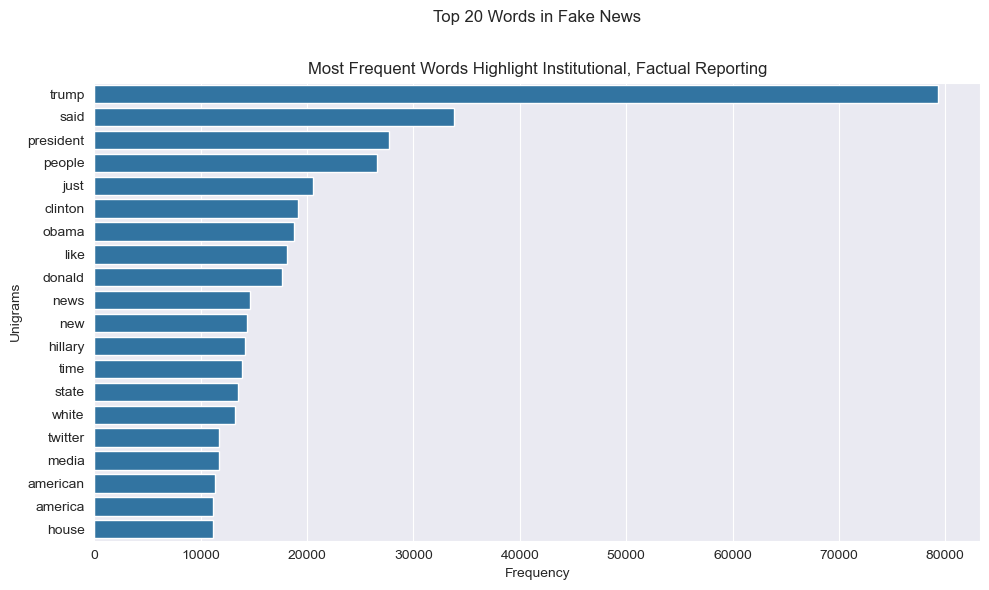

In [177]:
import pandas as pd

fake_texts= pd.DataFrame(fake_texts, columns=['word', 'freq'])
plot_top_words(
    fake_texts,
    title='Top 20 Words in Fake News\n\n\nMost Frequent Words Highlight Institutional, Factual Reporting',
    x_label='Frequency',
    y_label='Unigrams',
)

# eda for FNN data

## basic infos


In [128]:
(df_fnn.head(2))

,title,text,subject,label
0,Amal Clooney Puts a Twist on Daisy Dukes Durin...,Amal Clooney Puts a Twist on Daisy Dukes Durin...,Gossip,real
1,Scott Disick Like Donald Trump Jr Donald Trump,Scott Disick Like Donald Trump Jr Donald Trump,Gossip,fake


In [129]:
df_fnn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23196 entries, 0 to 23195
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23196 non-null  object
 1   text     23196 non-null  object
 2   subject  23196 non-null  object
 3   label    23196 non-null  object
dtypes: object(4)
memory usage: 725.0+ KB


In [130]:
df_fnn.describe()

,title,text,subject,label
count,23196,23196,23196,23196
unique,21724,21724,2,2
top,Connecting People Through News,Connecting People Through News,Gossip,real
freq,20,20,22140,17441


In [131]:
df_fnn.shape

(23196, 4)

### distribution

In [132]:
print("FNN labels:", df_fnn['label'].value_counts())


FNN labels: label
real    17441
fake     5755
Name: count, dtype: int64



## text length


In [146]:
print(df_fnn['text'].apply(lambda x: len(str(x))))


0        70
1        46
2        51
3        70
4        56
         ..
23191    78
23192    77
23193    63
23194    45
23195    50
Name: text, Length: 23196, dtype: int64


### check for null


In [134]:
df_fnn.isnull().sum()

title      0
text       0
subject    0
label      0
dtype: int64

### check for duplicate

In [144]:
df_fnn.duplicated().sum()


np.int64(1348)

## visualization


In [136]:
import seaborn as sns
import matplotlib.pyplot as plt


### Distribution


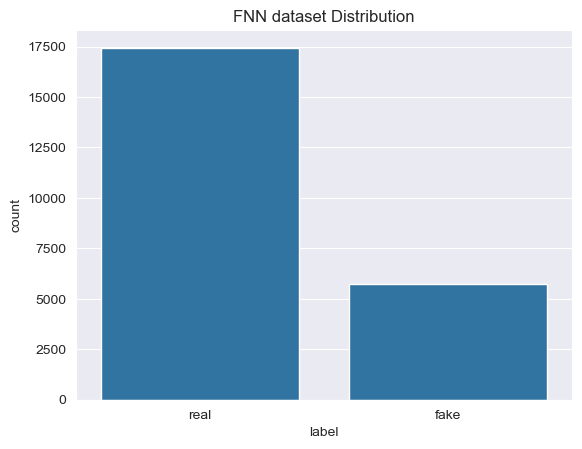

In [137]:
sns.countplot(data=df_fnn, x='label')
plt.title('FNN dataset Distribution')
plt.show()

### Text Lengths


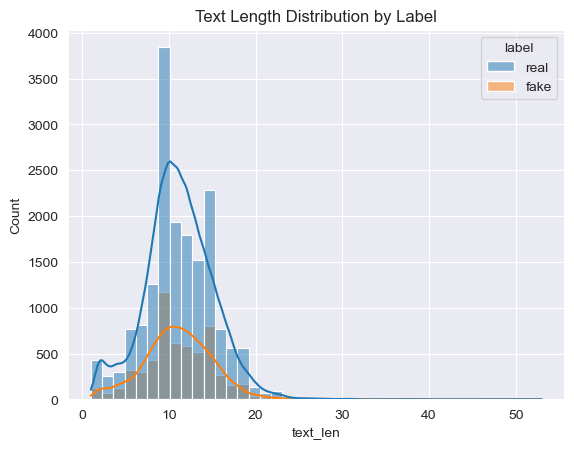

In [138]:
df_fnn['text_len'] = df_fnn['text'].apply(lambda x: len(str(x).split()))

sns.histplot(data=df_fnn, x='text_len', bins=40, hue='label', kde=True)
plt.title("Text Length Distribution by Label")
plt.show()
df_fnn.drop(columns=['text_len'], inplace=True)


### word cloud

In [139]:
generate_wordcloud(df_fnn, label="fake", source="fnn")


In [140]:
generate_wordcloud(df_fnn, label="real", source="fnn")


# eda for all

In [141]:
df_all.sample(2)

,title,text,subject,label
382,DON’T BELIEVE MEDIA LIES…Wildly Unpopular Hill...,This Facebook user s comment about Donald D...,politics,fake
37179,Hurricane Irma threatens Florida's bustling to...,NEW YORK (Reuters) - Hurricane Irma s path of ...,worldnews,real


In [149]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68094 entries, 0 to 68093
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    68094 non-null  object
 1   text     68094 non-null  object
 2   subject  68094 non-null  object
 3   label    68094 non-null  object
dtypes: object(4)
memory usage: 2.1+ MB


In [150]:
df_all.describe()

,title,text,subject,label
count,68094,68094,68094,68094
unique,60453,60370,10,2
top,Connecting People Through News,,Gossip,real
freq,20,627,22140,38858


In [151]:
df_all.shape

(68094, 4)

### distribution

In [152]:
print("ALL labels:", df_all['label'].value_counts())


ALL labels: label
real    38858
fake    29236
Name: count, dtype: int64


### text length

In [153]:
print(df_all['text'].apply(lambda x: len(str(x))))


0        2696
1        4432
2        2428
3        2342
4         531
         ... 
68089      66
68090      60
68091      56
68092      89
68093      45
Name: text, Length: 68094, dtype: int64
